# Geospatial file format Performance Evaluation

This notebook contains: 
- An Overview of the GeoParquet standard
- Benchmark code for evaluating the GeoParquet file format using the following datasets:
    - The [Google-Microsoft combined Open Buildings](https://beta.source.coop/vida/google-microsoft-open-buildings/) for 2D building footprint data
    - The [Overture buildings dataset](https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a) for 2.5D building data
        - Explore the impact of Overture's 
- A discussion of the current state of cloud-optimized geospatial file formats generally and the potential of GeoParquet specifically

# Introduction

 GeoParquet is [an incubating Open Geospatial Consortium (OGC) standard](https://geoparquet.org/) that simply adds compatible geospatial [geometry types](https://docs.safe.com/fme/html/FME-Form-Documentation/FME-ReadersWriters/geoparquet/Geometry-Support.htm) (MultiPoint, Line, Polygon, etc) to the mature and widely adopted Apache Parquet format, a popular columnar storage format commonly used in big data processing. Parquet is a mature file format and has a wide ecosystem that GeoParquet seamlessly integrates with. This is analogous to how the GeoTIFF raster format adds geospatial metadata to the TIFF standard. GeoParquet is designed to be a simple and efficient way to store geospatial *vector* data in a columnar format, and is designed to be compatible with existing Parquet tools and libraries to enable Cloud _Data Warehouse_ Interopability. 

A Parquet file is made up of a a set of file chunks called "row groups". Row groups are logical groups of columns with the same number of rows. Each of these columns is actually a "column chunk" which is a contiguous block of data for that column. The schema across row groups must be consistent, ie the data types and number of columns must be the same for every row group. The new geospatial standard adds some relevant additional metadata such as the geometry's Coordinate Reference System (CRS), additional metadata for geometry columns, and future realeses will enable support for spatial indexing. [Spatial indexing](https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b) is a technique used to optimize spatial queries by indexing or partitioning the data based on its geometry features such that you can make spatial queries (e.g. intersection, within, within x distance, etc) more efficiently. 

<figure>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*QEQJjtnDb3JQ2xqhzARZZw.png" style="width:100%">
<figcaption align = "center"> Visualization of the layout of a Parquet file </figcaption>
</figure>

Beyond the file data itself, Parquet also stores metadata at the end of the file that describes the internal "chunking" of the file, byte ranges of every column chunks, several column statistics, among other things. 

<figure>
<img src="https://guide.cloudnativegeo.org/images/geoparquet_layout.png" style="width:100%">
<figcaption align = "center"> GeoParquet has the same laylout with additional metadata </figcaption>
</figure>

 

## Features and Advantages

- Efficient storage and compression: 
    - leverages the columnar data format which is more efficient for filtering on columns
    - GeoParquet is internally compressed by default, and can be configured to optimize decompression time or storage size depending on the use case
    - These make it ideal for applications dealing with _massive_ geospatial datasets and cloud data warehouses
- Scalability and High-Performance:
    - the nature of the file format is well-suited for parallel and/or distributed processing such as in Spark, Dask, or Hadoop
    - Support for data partitioning: 
        - Parquet files can be partitioned by one or more columns
        - In the geospatial context this enables efficient spatial queries and filtering (e.g. partitioning by ISO country code) 
- Optimized for *read-heavy workflows*: 
    - Parquet is an immutable file format, which means taking advantage of cheap reads, and efficient filtering and aggregation operations
        - This is ideal for data warehousing and modern analytic workflows 
        - Best paired with Analytical Databases like Amazon Redshift, Google BigQuery, or DuckDB
        - Ideal for OLAP (Online Analytical Processing) and BI (Business Intelligence) workloads that leverage historical and aggregated data that don't require frequent updates
 - Interoperability and wide ecosystem:
    - GeoParquet is designed to be compatible with existing Parquet readers, tools, and libraries
    - Facilitates integration into existing data pipelines and workflows
    - Broad compatibility:
        - support for multiple spatial reference systems 
        - support for multiple geometry types and multiple geometry columns
        - works with both planar and spherical coordinates 
        - support for 2D and 3D geometries
        
## Limitations and Disadvantages

- Poorly suited for write-heavy workflows:
    - Transactional and CRUD (Create, Read, Update, Delete) operations are not well-suited for Parquet files
    - Not recommended for applications that require frequent updates or real-time data ingestion
- Not a Silver Bullet for all geospatial data:
    - deals only with vector data, not raster data
    - storage and compression benefits require a certain scale of data to be realized
    - performance overhead for small datasets
- Limited support for spatial indexing:
    - GeoParquet did not implement spatial indexing in the 1.0.0 release
    - This is planned for future release in 

# Benchmark Results

In [1]:
from dotenv import load_dotenv
import os

# Constants and local env configuration
load_dotenv() # take environment variables from .env 

# URI for combined open buildings data
combined_open_buildings_uri = "https://data.source.coop/vida/google-microsoft-open-buildings/geoparquet/by_country"

# use filepath loaded from env   
open_buildings_path = os.getenv("DATA_DIR") 
print("Open buildings data will be saved to: ", open_buildings_path)
# list of ISO country codes to fetch 
# buildings_countries = ["CUB","CHN", "AUS", "DEU" "USA"]
buildings_countries = ["BRB", "CAF", "JAM", "CUB", "GTM", "AUS"]
file_fmt_map = {"geojson":".geojson", "shapefile":".shp", "flatgeobuf":".fgb", "geopackage":".gpkg"}
format_gdal_names = {"geojson":"GeoJSON", "shapefile":"ESRI Shapefile", "flatgeobuf":"FlatGeobuf", "geopackage":"GPKG"}
compression_types = ["snappy", "gzip", "brotli", None]

Open buildings data will be saved to:  /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings


### Filesystem performance tests

In [2]:
from osgeo import gdal
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
# import time library to show download time
import time
import os
from glob import glob
import subprocess

def download_with_progress(url, local_file_path):
    response = urllib.request.urlopen(url)
    total_size = int(response.getheader('Content-Length').strip())
    block_size = 1024  # 1 Kibibyte

    with open(local_file_path, 'wb') as file, tqdm(
        desc=local_file_path,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        while True:
            buffer = response.read(block_size)
            if not buffer:
                break
            file.write(buffer)
            bar.update(len(buffer))

def fetch_geoparquet(country_code, output_dir):
    
    # fetch geoparquet from source.coop
    url = f"{combined_open_buildings_uri}/country_iso={country_code}/{country_code}.parquet"
    output_file = f"{output_dir}/{country_code}.parquet"
    print(f"Downloading {country_code}.parquet from:\n {url}")
    t1 = time.time()
    download_with_progress(url, output_file)
    t2 = time.time()
    print(f"Succesfully downloaded {country_code}.parquet in {t2-t1} seconds and saved to {output_file}")
    return output_file

def load_geodataframe(input_file, country_code, output_format="parquet", test_load=False):

    load_time = None
    # load geopandas dataframe from geoparquet
    if output_format == "parquet":
        # use timeit magic method to measure time taken to load
        if test_load:
            print(f"Testing load time for {country_code}.parquet")
            # get timeItResult object
            load_time = %timeit -r 1 -n 1 -o gpd.read_parquet(input_file)
            # save median of all_runs 
            load_time = np.median(load_time.all_runs)
        input_df = gpd.read_parquet(input_file)
    # load geopandas dataframe from other formats
    else:
        if test_load:
            print(f"Testing load time for {input_file.split('/')[-1]}")
            # get timeItResult object
            load_time = %timeit -r 1 -n 1 -o gpd.read_file(input_file)
            # save median of all_runs 
            load_time = np.median(load_time.all_runs)
        input_df = gpd.read_file(input_file)
    input_df.name = country_code
    print(f"Successfully loaded {country_code}.parquet into geopandas dataframe")
    
    return input_df, load_time

def pretty_print_df_info(input_df):
    print(f"Dataframe info for {input_df.name}:")
    print(input_df.info())
    print(input_df.head())

def get_output_path(input_file, output_format):
    # output path is same as input, but up two 
    # input has form /path/to/data/format/country_code.format
    country_code = input_file.split("/")[-1].split(".")[0] # use same country code for output file name
    output_file = "/".join(input_file.split("/")[:-2]) 
    # output file format is /path/to/data/format/country_code.format
    output_file = f"{output_file}/{output_format}/{country_code}{file_fmt_map[output_format]}"
    return output_file

In [3]:
# use ogr2ogr to convert geoparquet to our target formats; delete output file and return time taken and file size
def ogr_gdal_convert(input_file, output_format, delete_output=True, test_load=False):

    output_file = get_output_path(input_file, output_format)
    convert_time = time.time()
    file_size = 0
    load_time = None
    # get gdal format name
    input_format = input_file.split(".")[-1] # get file extension
    print(f"Starting conversion from {input_format} to {output_format}")
    gdal_format = format_gdal_names[output_format]
    command = ["ogr2ogr", "-f", gdal_format, output_file, input_file]
    result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    t2 = time.time()
    convert_time = t2 - convert_time
    
    # verify conversion result
    if result.returncode == 0:
        # calculate file size of converted file and convert to MB
        file_size = os.path.getsize(output_file) / (1024 * 1024)
        print(f"Successfully converted {input_file.split('/')[-1]} to {output_file.split('/')[-1]} in {convert_time:.2f}s")
        print(f"Converted file size: {file_size:.2f} MB")
        
    else:
        print(f"Error in conversion: {result.stderr.decode()}")
        return None, None, None
    
    if test_load:
        # load geopandas dataframe from converted file
        country_code = input_file.split("/")[-1].split(".")[0] 
        _, load_time = load_geodataframe(input_file=output_file, country_code=country_code, output_format=output_format, test_load=True)

    # delete output file
    if delete_output:
        # delete other files like in the case of shapefile
        for file in glob(f"{output_file.split('.')[0]}*"):
            os.remove(file)
        
    return convert_time, file_size, load_time

# use geopandas to save to our target formats from existing dataframe; delete output file and return time taken and file size
def geopandas_convert(input_df, output_format, delete_output=True):
    
    # get country_code from input_df
    output_file = f"{open_buildings_path}/{output_format}/{input_df.name}{file_fmt_map[output_format]}"
    convert_time = time.time()
    load_time = None
    
    try:
        input_df.to_file(output_file, driver=format_gdal_names[output_format])
        t2 = time.time()
        convert_time = t2 - convert_time
    except Exception as e:
        print(f"Error converting {input_df} to {output_format}: {e}")
        return None, None

    # calculate file size of converted file and convert to MB
    file_size = os.path.getsize(output_file) / (1024 * 1024)
    # delete output file
    if delete_output:
        # delete other files like in the case of shapefile
        for file in glob(f"{output_file.split('.')[0]}*"):
            os.remove(file) 
            
    print(f"Successfully converted {input_df.name} gdf to {output_file.split('/')[-1]} in {convert_time:.2f}s")
    print(f"{output_format} file size: {file_size:.2f} MB")

    return convert_time, file_size

# use duckdb to read in geoparquet and save to our target formats
def duckdb_convert(input_file, output_format):
    output_file = get_output_path(input_file, output_format)

# receive geopandas df, save file to disk using specified algorithm, delete output file and return time taken and file size
def gdf_to_compressed_geoparquet(input_df, compression_type, test_load=False):
    
    output_file = f"{open_buildings_path}/parquet/{input_df.name}_{compression_type}.parquet"
    convert_time = time.time()
    load_time = None

    try:
        input_df.to_parquet(output_file, compression=compression_type, schema_version='1.0.0')
        t2 = time.time()
        convert_time = t2 - convert_time
    except Exception as e:
        print(f"Error saving {input_df.name} gdf to geoparquet compressed with {compression_type}: {e}")
    
    # calculate file size of converted file and convert to MB
    file_size = os.path.getsize(output_file) / (1024 * 1024)
    
    if test_load:
        print(f"Testing load time for {input_df.name}_{compression_type}.parquet")
        # load geopandas dataframe from converted file
        _, load_time = load_geodataframe(input_file=output_file, country_code=input_df.name, output_format="parquet", test_load=True)
    
    
    # delete output file
    os.remove(output_file)
    print(f"Successfully saved {input_df.name} gdf to geoparquet compressed with {compression_type} in {convert_time} seconds.")
    print(f"Converted file size: {file_size} MB")    

    return convert_time, file_size, load_time

In [4]:
import pandas as pd

# benchmark performance of converting to other vector formats 

def convert_benchmark(country_list, file_formats, data_dir, delete_output, test_load):
    
    # initialize stats for conversion
    convert_stats = {
            "processing_time": [], # for different conversion methods (ogr2ogr, geopandas, duckdb)
            "file_size": 0.0, 
            "load_time": 0.0 # time taken to load converted file into geopandas dataframe
    }
    conversion_stats = {}    
    
    # go through each country code, fetch geoparquet, convert to target formats, and records some stats
    for country_code in country_list:
        
        # download geoparquet for each benchmarked country if not already downloaded
        input_file = f"{data_dir}/parquet/{country_code}.parquet"
        if not os.path.exists(f"{data_dir}/parquet/{country_code}.parquet"):
            print(f"{country_code}.parquet not found, fetching from source.coop...")
            input_file = fetch_geoparquet(country_code, f"{data_dir}/parquet")
        else:
            print(f"{country_code}.parquet found at {input_file}")
        conversion_stats[country_code] = {}

        # calculate processing time and file size for geoparquet 
        parquet_file_size = os.path.getsize(input_file) / (1024 * 1024)
        country_gdf, load_time = load_geodataframe(input_file, country_code, output_format="parquet", test_load=test_load)
        conversion_stats[country_code]["parquet"] = {"file_size": parquet_file_size, "processing_time": [0.0, 0.0], "load_time": load_time}
        
        for output_format in file_formats:
            # create output dir for each file format if it doesn't exist
            output_dir = f"{data_dir}/{output_format}"
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            # initialize stats for country_code and output_format
            conversion_stats[country_code][output_format] = convert_stats.copy() 
            # gdal/ogr2ogr conversion
            ogr_time, ogr_size, load_time = ogr_gdal_convert(input_file, output_format, delete_output, test_load)
            # geopandas conversion
            gpd_time, gpd_size = geopandas_convert(country_gdf, output_format, delete_output)
            # duckdb conversion
            # TODO: implement duckdb conversion
            
            # record stats
            conversion_stats[country_code][output_format]["processing_time"] = [ogr_time, gpd_time]
            # file size for a given format should be mostly the same, so we take the max
            conversion_stats[country_code][output_format]["file_size"] = max(ogr_size, gpd_size)
            conversion_stats[country_code][output_format]["load_time"] = load_time
            # format to two decimal places
            print(f"file sizes for {output_format} - ogr/gdal:{ogr_size:.2f} MB, geopandas:{gpd_size:.2f} MB")
    
    return conversion_stats
        
 # benchmark compression performance of geoparquet
 
def compress_benchmark(country_list, compression_types, data_dir, delete_output, test_load):
     
    # initialize stats for compression
    compress_stats = {
                        "compression_size": 0.0,
                        "compression_time": 0.0,
                        "load_time": 0.0, 
                        "geom_count": 0
    }
    compression_stats = {}
    # go through each country code, fetch geoparquet, convert to target formats, and records some stats
    for country_code in country_list:
    
        # download geoparquet for each benchmarked country if not already downloaded
        input_file = f"{data_dir}/parquet/{country_code}.parquet"
        if not os.path.exists(f"{open_buildings_path}/parquet/{country_code}.parquet"):
            print(f"{country_code}.parquet not found, fetching from source.coop...")
            input_file = fetch_geoparquet(country_code, f"{data_dir}/parquet")
        else:
            print(f"{country_code}.parquet found at {input_file}")
    
        country_gdf, _ = load_geodataframe(input_file, country_code)
        geom_count = len(country_gdf)
        compression_stats[country_code] = {}

        # compress geopandas dataframe
        for ctype in compression_types:
            
            ctype = "None" if ctype is None else ctype
            compression_stats[country_code][ctype] = compress_stats.copy()
            compress_time, compress_size, load_time = gdf_to_compressed_geoparquet(country_gdf, ctype, test_load=test_load)
            compression_stats[country_code][ctype]["compression_time"] = compress_time
            compression_stats[country_code][ctype]["compression_size"] = compress_size
            compression_stats[country_code][ctype]["load_time"] = load_time
            compression_stats[country_code][ctype]["geom_count"] = geom_count
        
    return compression_stats

def flatten_benchmark_stats(stats, column_name, stats_names):
    
    # both dicts have the same two levels of keys (country_code and output_format/compression_type)
    # flatten dict into single level of columns
    data = []
    for country_code, country_stats in stats.items():
        # print(country_code, country_stats)
        for key, stats in country_stats.items():
            # print(key, stats)
            row = {"country_code": country_code, column_name: key}
            for stat_name in stats_names:
                row[stat_name] = stats[stat_name]
            data.append(row)
    
    df = pd.DataFrame(data)
    return df
    

# full benchmarking pipeline
def full_benchmark(country_list, file_formats, compression_types, data_dir, delete_output, test_load):
    
    print("Testing conversion performance...")
    conversion_stats = convert_benchmark(country_list, file_formats, data_dir, delete_output, test_load)
    print("Testing compression performance...")
    compression_stats = compress_benchmark(country_list, compression_types, data_dir, delete_output, test_load)
    
    return conversion_stats, compression_stats

In [5]:
# run full benchmarking pipeline
conversion_stats, compression_stats = full_benchmark(country_list=buildings_countries,
                                                        file_formats=list(file_fmt_map.keys()),
                                                        compression_types=compression_types,
                                                        data_dir=open_buildings_path,
                                                        delete_output=True,
                                                        test_load=True)

Testing conversion performance...
BRB.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/BRB.parquet
Testing load time for BRB.parquet
254 ms ± 69.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded BRB.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully converted BRB.parquet to BRB.geojson in 3.98s
Converted file size: 100.30 MB
Testing load time for BRB.geojson
17.8 s ± 121 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.geojson in 19.71s
geojson file size: 100.30 MB
file sizes for geojson - ogr/gdal:100.30 MB, geopandas:100.30 MB
Starting conversion from parquet to shapefile
Successfully converted BRB.parquet to BRB.shp in 1.23s
Converted file size: 34.03 MB
Testing load time for BRB.shp
14 s ± 594 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded BRB.parquet int

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_57140/1918500258.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=format_gdal_names[output_format])


Successfully converted BRB gdf to BRB.shp in 16.56s
shapefile file size: 34.03 MB
file sizes for shapefile - ogr/gdal:34.03 MB, geopandas:34.03 MB
Starting conversion from parquet to flatgeobuf
Successfully converted BRB.parquet to BRB.fgb in 0.76s
Converted file size: 56.87 MB
Testing load time for BRB.fgb
13.7 s ± 637 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.fgb in 15.99s
flatgeobuf file size: 56.87 MB
file sizes for flatgeobuf - ogr/gdal:56.87 MB, geopandas:56.87 MB
Starting conversion from parquet to geopackage
Successfully converted BRB.parquet to BRB.gpkg in 0.87s
Converted file size: 56.48 MB
Testing load time for BRB.gpkg
13.4 s ± 92.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.gpkg in 26.36s
geopackage file size: 55.50 MB
file sizes for geopackage - ogr/gdal:56.48 MB

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_57140/1918500258.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=format_gdal_names[output_format])


Successfully converted CUB gdf to CUB.shp in 369.49s
shapefile file size: 727.98 MB
file sizes for shapefile - ogr/gdal:727.98 MB, geopandas:727.98 MB
Starting conversion from parquet to flatgeobuf
Successfully converted CUB.parquet to CUB.fgb in 23.32s
Converted file size: 1235.37 MB
Testing load time for CUB.fgb
4min 58s ± 818 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded CUB.parquet into geopandas dataframe
Successfully converted CUB gdf to CUB.fgb in 349.48s
flatgeobuf file size: 1235.36 MB
file sizes for flatgeobuf - ogr/gdal:1235.37 MB, geopandas:1235.36 MB
Starting conversion from parquet to geopackage
Successfully converted CUB.parquet to CUB.gpkg in 17.20s
Converted file size: 1236.34 MB
Testing load time for CUB.gpkg
4min 56s ± 916 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded CUB.parquet into geopandas dataframe
Successfully converted CUB gdf to CUB.gpkg in 358.76s
geopackage file size: 1210.97 MB
file sizes for geopack

/Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/JAM.parquet: 100%|██████████| 120M/120M [00:04<00:00, 30.0MiB/s] 


Succesfully downloaded JAM.parquet in 5.752295732498169 seconds and saved to /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/JAM.parquet
Testing load time for JAM.parquet
1.26 s ± 145 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded JAM.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully converted JAM.parquet to JAM.geojson in 25.32s
Converted file size: 694.41 MB
Testing load time for JAM.geojson
1min 59s ± 160 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded JAM.parquet into geopandas dataframe
Successfully converted JAM gdf to JAM.geojson in 129.87s
geojson file size: 694.41 MB
file sizes for geojson - ogr/gdal:694.41 MB, geopandas:694.41 MB
Starting conversion from parquet to shapefile
Successfully converted JAM.parquet to JAM.shp in 7.73s
Converted file size: 233.05 MB
Testing load time for JAM.shp
1min 35s ± 403 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Succe

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_57140/1918500258.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=format_gdal_names[output_format])


Successfully converted JAM gdf to JAM.shp in 121.50s
shapefile file size: 233.05 MB
file sizes for shapefile - ogr/gdal:233.05 MB, geopandas:233.05 MB
Starting conversion from parquet to flatgeobuf
Successfully converted JAM.parquet to JAM.fgb in 5.73s
Converted file size: 392.64 MB
Testing load time for JAM.fgb
1min 33s ± 554 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded JAM.parquet into geopandas dataframe
Successfully converted JAM gdf to JAM.fgb in 114.65s
flatgeobuf file size: 392.64 MB
file sizes for flatgeobuf - ogr/gdal:392.64 MB, geopandas:392.64 MB
Starting conversion from parquet to geopackage
Successfully converted JAM.parquet to JAM.gpkg in 5.42s
Converted file size: 389.33 MB
Testing load time for JAM.gpkg
1min 33s ± 873 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Successfully loaded JAM.parquet into geopandas dataframe
Successfully converted JAM gdf to JAM.gpkg in 120.33s
geopackage file size: 382.24 MB
file sizes for geopackage - og

In [6]:
convert_stats = ["processing_time", "file_size", "load_time"]
convert_stats_df = flatten_benchmark_stats(stats=conversion_stats, column_name="output_format", stats_names=convert_stats)

compress_stats = ["compression_time", "compression_size", "load_time", "geom_count"]
compress_stats_df = flatten_benchmark_stats(stats=compression_stats, column_name="compression_type", stats_names=compress_stats)

In [7]:
convert_stats_df

,country_code,output_format,processing_time,file_size,load_time
0,BRB,parquet,"[0.0, 0.0]",17.839197,0.205124
1,BRB,geojson,"[3.9769060611724854, 19.7092068195343]",100.300326,17.807595
2,BRB,shapefile,"[1.2344160079956055, 16.558977842330933]",34.027241,13.572332
3,BRB,flatgeobuf,"[0.7623240947723389, 15.991793155670166]",56.874390,13.250406
4,BRB,geopackage,"[0.8696789741516113, 26.363568782806396]",56.476562,13.392151
5,CUB,parquet,"[0.0, 0.0]",372.577253,4.160017
6,CUB,geojson,"[77.94618582725525, 442.21526288986206]",2189.446841,395.419709
7,CUB,shapefile,"[26.623476028442383, 369.4864478111267]",727.984657,315.477132
8,CUB,flatgeobuf,"[23.31838607788086, 349.4812321662903]",1235.365303,299.026272
9,CUB,geopackage,"[17.203861951828003, 358.758024930954]",1236.335938,296.023690


In [8]:
compress_stats_df

,country_code,compression_type,compression_time,compression_size,load_time,geom_count
0,BRB,snappy,0.329370,20.471449,0.164407,243271
1,BRB,gzip,1.203303,15.824190,0.229064,243271
2,BRB,brotli,1.450911,14.441882,0.220774,243271
3,BRB,None,0.302349,27.163264,0.150452,243271
4,CUB,snappy,6.486471,418.394654,4.616885,5412454
5,CUB,gzip,22.995844,321.314292,5.349254,5412454
6,CUB,brotli,30.630411,296.194871,5.174390,5412454
7,CUB,None,6.386583,570.181287,4.567641,5412454
8,JAM,snappy,1.917944,135.129596,1.126711,1702655
9,JAM,gzip,7.672504,104.020254,1.389114,1702655


In [25]:
    # in output format column, change "parquet" to "geoparquet"
    convert_stats_df["output_format"] = convert_stats_df["output_format"].apply(lambda x: "geoparquet" if x == "parquet" else x)
    # add geom_count column to convert_stats_df by joining on country_code
    convert_stats_df = convert_stats_df.merge(compress_stats_df[["country_code", "geom_count"]], on="country_code")
    # display updated convert_stats_df  
    convert_stats_df

,country_code,output_format,processing_time,file_size,load_time,geom_count
0,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.205124,243271
1,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.205124,243271
2,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.205124,243271
3,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.205124,243271
4,BRB,geojson,"[3.9769060611724854, 19.7092068195343]",100.300326,17.807595,243271
5,BRB,geojson,"[3.9769060611724854, 19.7092068195343]",100.300326,17.807595,243271
6,BRB,geojson,"[3.9769060611724854, 19.7092068195343]",100.300326,17.807595,243271
7,BRB,geojson,"[3.9769060611724854, 19.7092068195343]",100.300326,17.807595,243271
8,BRB,shapefile,"[1.2344160079956055, 16.558977842330933]",34.027241,13.572332,243271
9,BRB,shapefile,"[1.2344160079956055, 16.558977842330933]",34.027241,13.572332,243271


In [21]:
convert_stats_df.name = "Conversion Stats"
# save to csv with country_codes in filename
country_codes = "_".join(convert_stats_df["country_code"].unique())
convert_stats_df.to_csv(f"{open_buildings_path}/benchmark_{country_codes}_conversion.csv", index=False)
pretty_print_df_info(convert_stats_df)

Dataframe info for Conversion Stats:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_code     15 non-null     object 
 1   output_format    15 non-null     object 
 2   processing_time  15 non-null     object 
 3   file_size        15 non-null     float64
 4   load_time        15 non-null     float64
dtypes: float64(2), object(3)
memory usage: 728.0+ bytes
None
  country_code output_format                           processing_time  \
0          BRB    geoparquet                                [0.0, 0.0]   
1          BRB       geojson    [3.9769060611724854, 19.7092068195343]   
2          BRB     shapefile  [1.2344160079956055, 16.558977842330933]   
3          BRB    flatgeobuf  [0.7623240947723389, 15.991793155670166]   
4          BRB    geopackage  [0.8696789741516113, 26.363568782806396]   

    file_size  load_time  
0   1

### Plotting performance results

In [1]:
# functions for plotting stats with seaborn

import seaborn as sns

def barplot(data, x, y, title, xlabel, ylabel, hue=None, orient='v', color=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create horizontal barplot
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, orient=orient, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)    
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

def scatter_plot(data, x, y, title, xlabel, ylabel, hue=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create scatter plot
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticklabels(xticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

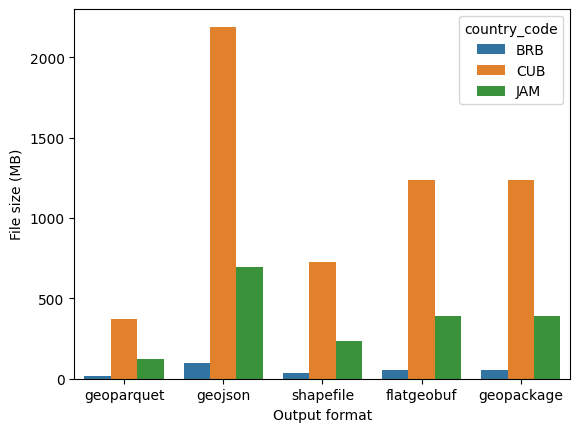

In [23]:
# create a grouped bar plot where y is file size and x is file format and file sizes are grouped by country code
barplot(data=convert_stats_df, x="output_format", y="file_size", title="File size by output format", xlabel="Output format", ylabel="File size (MB)", hue="country_code")

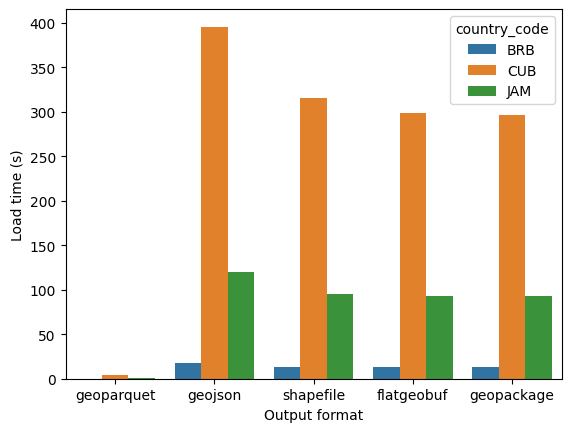

In [24]:
# create a grouped bar plot where y is load time and x is file format and load times are grouped by country code
barplot(data=convert_stats_df, x="output_format", y="load_time", title="Load time by output format", xlabel="Output format", ylabel="Load time (s)", hue="country_code")

In [2]:
# check df columns types
convert_stats_df.dtypes

NameError: name 'convert_stats_df' is not defined

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_57140/1416476384.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_57140/1416476384.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


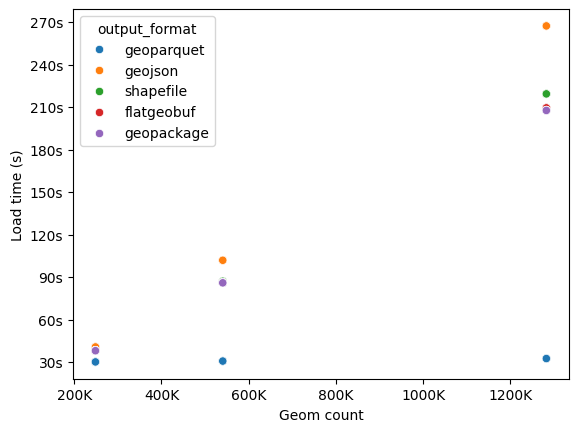

In [37]:
# modify xticks for geom_count to display 200K ticks up to max geom_count in dataset
xticks = [i for i in range(0, max(convert_stats_df["geom_count"]), 200000)]

print()
# modify yticks for load_time to display 30s ticks up to max load_time in dataset
yticks = [f"{i}s" for i in range(0, max(convert_stats_df["load_time"].astype(int)), 30)]

# create a scatter plot where x is geom count and y is load time and points are colored by file format
scatter_plot(data=convert_stats_df, x="geom_count", y="load_time", title="Load time by geom count", xlabel="Geom count", ylabel="Load time (s)", hue="output_format", xticks=xticks, yticks=yticks)

### Querying in-memory with GeoPandas 

Query brainstorming: 
- simple geometry/building count per country
    - visualization: interactive international map with countries shaded or scaled by building count
- distribution of square area of buildings per country or per other attribute
    - comparison of square area distributions between countries
        - how do we compare/match distributions? descriptive statistics? 
- 

### Querying from files with DuckDB

### Visualization with Basemaps

### 3D Data with Overture

# Discussion on cloud-native geospatial data formats

# References
- https://geoparquet.org/
- https://geopandas.org/
- https://radiant.earth/blog/2023/10/what-is-source-cooperative/
- https://guide.cloudnativegeo.org/geoparquet/
- https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a
- https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b
- https://github.com/opengeospatial/geoparquet/blob/main/format-specs/geoparquet.md 
- https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2